# Adaptive Beamforming Test
## Comparing DAS, MVDR (Capon), and MUSIC algorithms

This notebook demonstrates the differences between:
- **DAS (Delay-and-Sum)**: Basic beamforming with fixed weights
- **MVDR (Minimum Variance Distortionless Response)**: Adaptive beamforming (Capon method)
- **MUSIC (Multiple Signal Classification)**: Subspace-based super-resolution method

In [12]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

from algorithms.beamforming import (
    load_mic_geometry,
    create_focus_grid,
    das_beamformer,
    mvdr_beamformer_fast,
    music_beamformer,
    create_synthetic_signal,
    power_to_db,
    BeamformingConfig
)

print('✓ Imports successful')

✓ Imports successful


Loaded 16 microphones


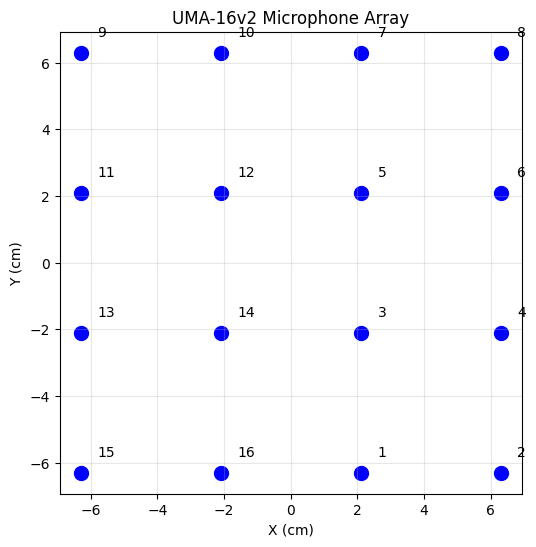

In [13]:
# Load microphone geometry
mic_positions = load_mic_geometry(str(project_root / 'micgeom.xml'))
print(f'Loaded {len(mic_positions)} microphones')

# Visualize mic positions
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(mic_positions[:, 0] * 100, mic_positions[:, 1] * 100, s=100, c='blue')
for i, pos in enumerate(mic_positions):
    ax.annotate(f'{i+1}', (pos[0]*100 + 0.5, pos[1]*100 + 0.5))
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title('UMA-16v2 Microphone Array')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.show()

In [14]:
# Configuration
config = BeamformingConfig(
    grid_size_x=0.6,
    grid_size_y=0.6,
    grid_resolution=0.02,
    focus_distance=1.0,
    freq_min=1900,
    freq_max=2100,
    field_type='near-field'
)

grid_points, grid_shape = create_focus_grid(config)
print(f'Grid: {grid_shape[0]}x{grid_shape[1]} = {len(grid_points)} points')

Grid: 31x31 = 961 points


In [15]:
# Generate synthetic signal from a known source position
source_position = np.array([0.1, -0.1, 1.0])  # 10cm right, 10cm down, 1m away
frequency = 2000.0
sample_rate = 48000
n_samples = 4096

signals = create_synthetic_signal(
    mic_positions,
    source_position,
    frequency,
    sample_rate,
    n_samples,
    noise_level=0.1
)

print(f'Signals shape: {signals.shape}')
print(f'Source position: X={source_position[0]*100:.0f}cm, Y={source_position[1]*100:.0f}cm, Z={source_position[2]*100:.0f}cm')

Signals shape: (4096, 16)
Source position: X=10cm, Y=-10cm, Z=100cm


In [16]:
# Run all three beamformers and measure time
import time

# DAS
t0 = time.perf_counter()
power_das = das_beamformer(signals, mic_positions, grid_points, sample_rate, config)
t_das = (time.perf_counter() - t0) * 1000

# MVDR
t0 = time.perf_counter()
power_mvdr = mvdr_beamformer_fast(signals, mic_positions, grid_points, sample_rate, config)
t_mvdr = (time.perf_counter() - t0) * 1000

# MUSIC
t0 = time.perf_counter()
power_music = music_beamformer(signals, mic_positions, grid_points, sample_rate, config, n_sources=1)
t_music = (time.perf_counter() - t0) * 1000

print(f'Processing times:')
print(f'  DAS:   {t_das:.1f} ms')
print(f'  MVDR:  {t_mvdr:.1f} ms')
print(f'  MUSIC: {t_music:.1f} ms')

Processing times:
  DAS:   10.6 ms
  MVDR:  10.8 ms
  MUSIC: 11.4 ms


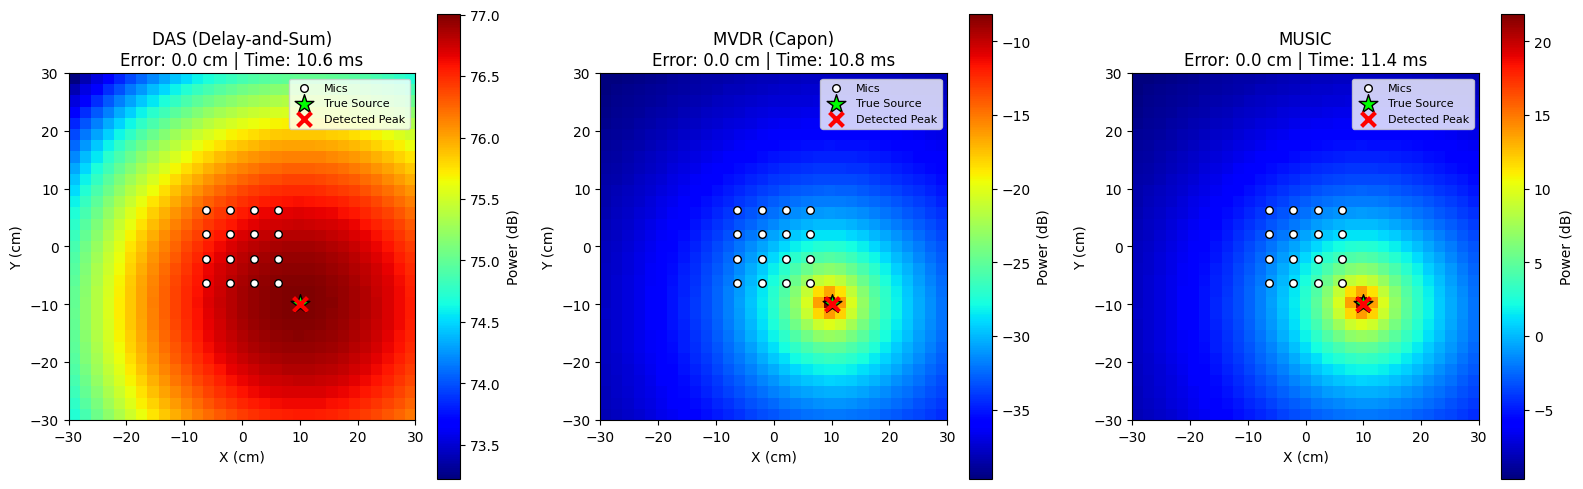

In [17]:
# Compare results visually
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

extent = [-config.grid_size_x/2 * 100, config.grid_size_x/2 * 100,
          -config.grid_size_y/2 * 100, config.grid_size_y/2 * 100]

for ax, power, title, timing in zip(
    axes, 
    [power_das, power_mvdr, power_music],
    ['DAS (Delay-and-Sum)', 'MVDR (Capon)', 'MUSIC'],
    [t_das, t_mvdr, t_music]
):
    power_db = power_to_db(power)
    power_grid = power_db.reshape(grid_shape)
    
    im = ax.imshow(power_grid, origin='lower', extent=extent, cmap='jet', aspect='equal')
    
    # Plot microphones
    ax.scatter(mic_positions[:, 0] * 100, mic_positions[:, 1] * 100, 
               c='white', s=30, marker='o', edgecolors='black', label='Mics')
    
    # Plot true source position
    ax.scatter(source_position[0] * 100, source_position[1] * 100, 
               c='lime', s=200, marker='*', edgecolors='black', label='True Source')
    
    # Find and mark detected peak
    peak_idx = np.argmax(power)
    peak_pos = grid_points[peak_idx]
    ax.scatter(peak_pos[0] * 100, peak_pos[1] * 100, 
               c='red', s=100, marker='x', linewidths=3, label='Detected Peak')
    
    # Calculate error
    error = np.linalg.norm(peak_pos[:2] - source_position[:2]) * 100  # cm
    
    ax.set_title(f'{title}\nError: {error:.1f} cm | Time: {timing:.1f} ms')
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    plt.colorbar(im, ax=ax, label='Power (dB)')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

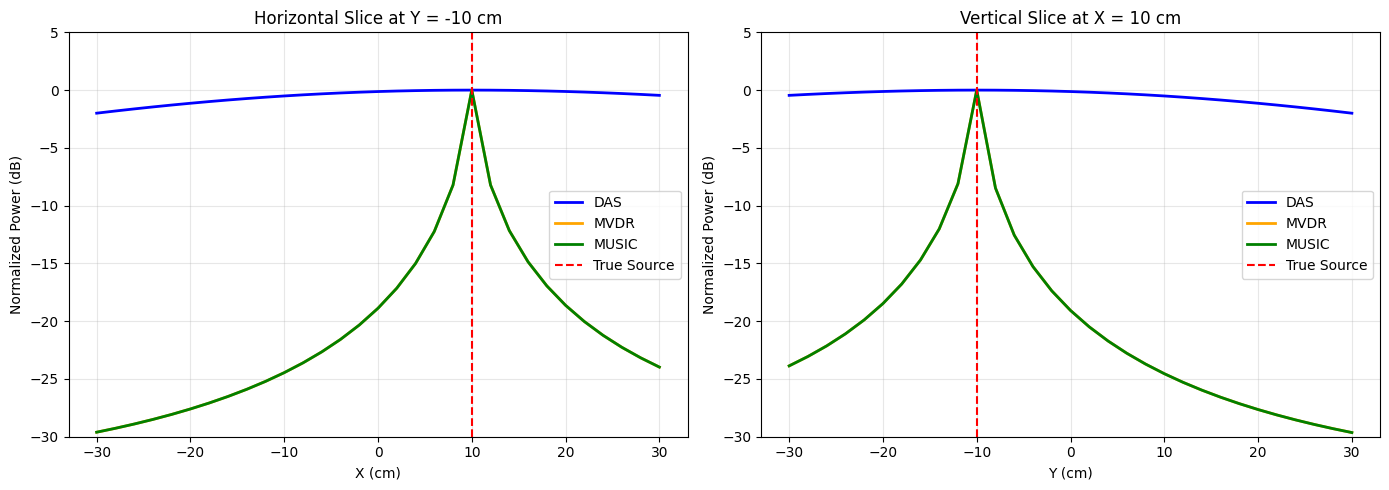

In [18]:
# Cross-section analysis (slice through the source position)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Find the row/col indices closest to source position
n_x = int(config.grid_size_x / config.grid_resolution) + 1
n_y = int(config.grid_size_y / config.grid_resolution) + 1
x_coords = np.linspace(-config.grid_size_x/2, config.grid_size_x/2, n_x)
y_coords = np.linspace(-config.grid_size_y/2, config.grid_size_y/2, n_y)

source_col = np.argmin(np.abs(x_coords - source_position[0]))
source_row = np.argmin(np.abs(y_coords - source_position[1]))

# Horizontal slice (constant Y)
ax = axes[0]
for power, label, color in zip(
    [power_das, power_mvdr, power_music],
    ['DAS', 'MVDR', 'MUSIC'],
    ['blue', 'orange', 'green']
):
    power_db = power_to_db(power)
    power_grid = power_db.reshape(grid_shape)
    slice_h = power_grid[source_row, :]
    # Normalize to 0 dB max
    slice_h_norm = slice_h - slice_h.max()
    ax.plot(x_coords * 100, slice_h_norm, label=label, color=color, linewidth=2)

ax.axvline(source_position[0] * 100, color='red', linestyle='--', label='True Source')
ax.set_xlabel('X (cm)')
ax.set_ylabel('Normalized Power (dB)')
ax.set_title(f'Horizontal Slice at Y = {source_position[1]*100:.0f} cm')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-30, 5)

# Vertical slice (constant X)
ax = axes[1]
for power, label, color in zip(
    [power_das, power_mvdr, power_music],
    ['DAS', 'MVDR', 'MUSIC'],
    ['blue', 'orange', 'green']
):
    power_db = power_to_db(power)
    power_grid = power_db.reshape(grid_shape)
    slice_v = power_grid[:, source_col]
    # Normalize to 0 dB max
    slice_v_norm = slice_v - slice_v.max()
    ax.plot(y_coords * 100, slice_v_norm, label=label, color=color, linewidth=2)

ax.axvline(source_position[1] * 100, color='red', linestyle='--', label='True Source')
ax.set_xlabel('Y (cm)')
ax.set_ylabel('Normalized Power (dB)')
ax.set_title(f'Vertical Slice at X = {source_position[0]*100:.0f} cm')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-30, 5)

plt.tight_layout()
plt.show()

## Test with Multiple Sources

MVDR and MUSIC are particularly good at resolving multiple sources.

In [19]:
# Generate signal with two sources
source1 = np.array([0.05, 0.0, 1.0])   # 5cm right
source2 = np.array([-0.05, 0.0, 1.0])  # 5cm left

freq1, freq2 = 2000.0, 2000.0  # Same frequency (harder case)

# Generate signals from both sources
signals1 = create_synthetic_signal(mic_positions, source1, freq1, sample_rate, n_samples, noise_level=0.05)
signals2 = create_synthetic_signal(mic_positions, source2, freq2, sample_rate, n_samples, noise_level=0.05)

# Combine signals
signals_combined = signals1 + signals2

print(f'Source 1: X={source1[0]*100:.0f}cm, Y={source1[1]*100:.0f}cm')
print(f'Source 2: X={source2[0]*100:.0f}cm, Y={source2[1]*100:.0f}cm')
print(f'Source separation: {np.linalg.norm(source1[:2] - source2[:2])*100:.1f} cm')

Source 1: X=5cm, Y=0cm
Source 2: X=-5cm, Y=0cm
Source separation: 10.0 cm


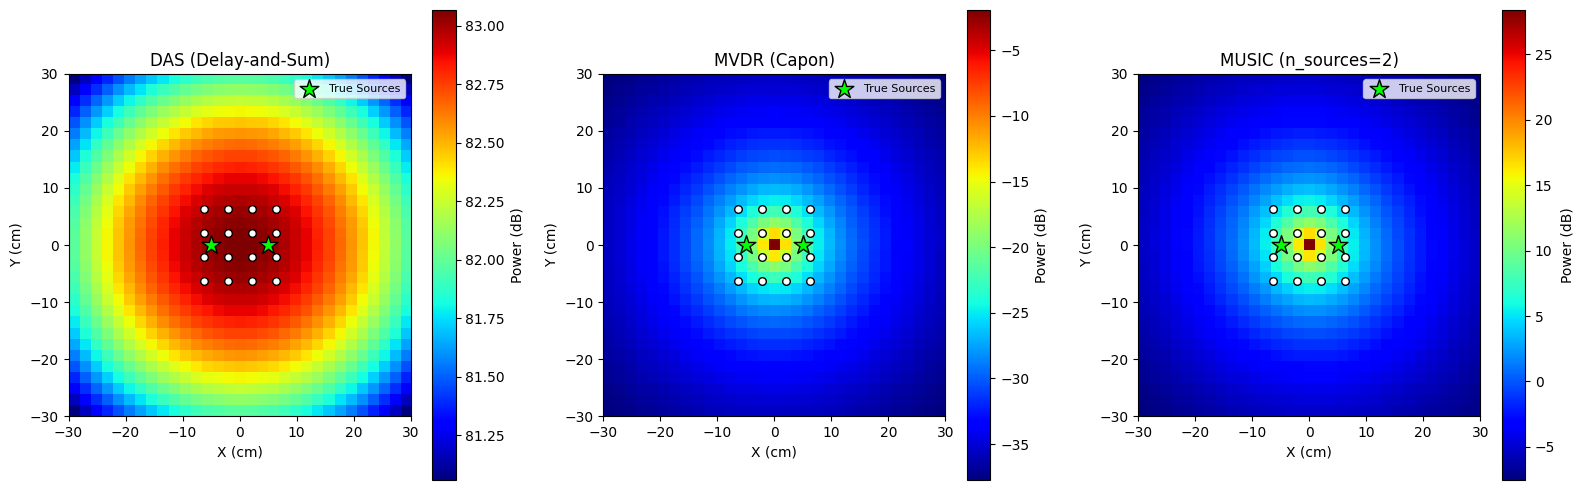

In [20]:
# Run beamformers on two-source signal
power_das_2 = das_beamformer(signals_combined, mic_positions, grid_points, sample_rate, config)
power_mvdr_2 = mvdr_beamformer_fast(signals_combined, mic_positions, grid_points, sample_rate, config)
power_music_2 = music_beamformer(signals_combined, mic_positions, grid_points, sample_rate, config, n_sources=2)

# Compare results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, power, title in zip(
    axes, 
    [power_das_2, power_mvdr_2, power_music_2],
    ['DAS (Delay-and-Sum)', 'MVDR (Capon)', 'MUSIC (n_sources=2)']
):
    power_db = power_to_db(power)
    power_grid = power_db.reshape(grid_shape)
    
    im = ax.imshow(power_grid, origin='lower', extent=extent, cmap='jet', aspect='equal')
    
    # Plot microphones
    ax.scatter(mic_positions[:, 0] * 100, mic_positions[:, 1] * 100, 
               c='white', s=30, marker='o', edgecolors='black')
    
    # Plot true source positions
    ax.scatter([source1[0]*100, source2[0]*100], [source1[1]*100, source2[1]*100], 
               c='lime', s=200, marker='*', edgecolors='black', label='True Sources')
    
    ax.set_title(f'{title}')
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    plt.colorbar(im, ax=ax, label='Power (dB)')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

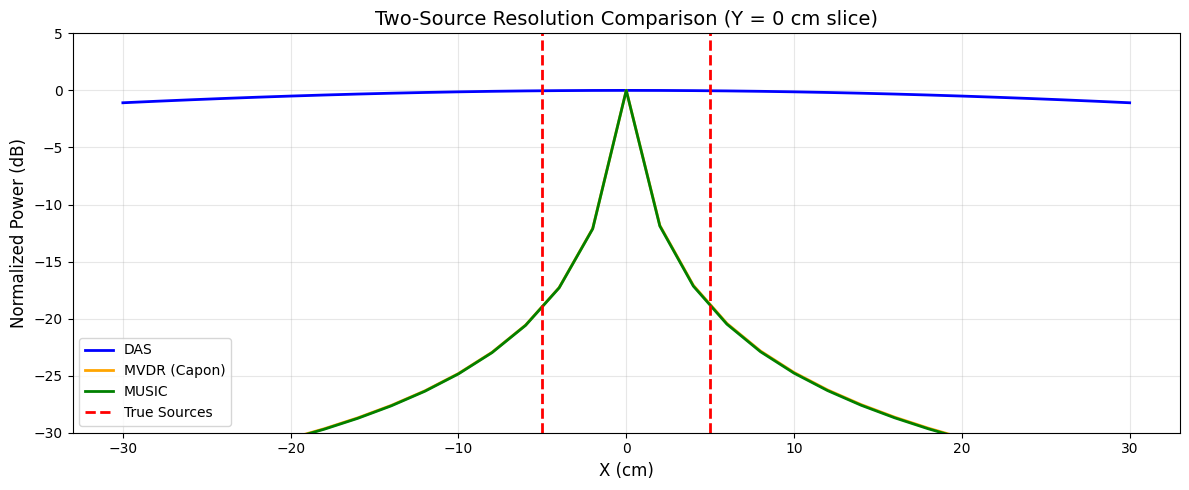

In [21]:
# Cross-section through the two sources (Y=0)
fig, ax = plt.subplots(figsize=(12, 5))

center_row = n_y // 2  # Y = 0

for power, label, color, ls in zip(
    [power_das_2, power_mvdr_2, power_music_2],
    ['DAS', 'MVDR (Capon)', 'MUSIC'],
    ['blue', 'orange', 'green'],
    ['-', '-', '-']
):
    power_db = power_to_db(power)
    power_grid = power_db.reshape(grid_shape)
    slice_h = power_grid[center_row, :]
    # Normalize
    slice_h_norm = slice_h - slice_h.max()
    ax.plot(x_coords * 100, slice_h_norm, label=label, color=color, linewidth=2, linestyle=ls)

# Mark true source positions
ax.axvline(source1[0] * 100, color='red', linestyle='--', linewidth=2, label='True Sources')
ax.axvline(source2[0] * 100, color='red', linestyle='--', linewidth=2)

ax.set_xlabel('X (cm)', fontsize=12)
ax.set_ylabel('Normalized Power (dB)', fontsize=12)
ax.set_title('Two-Source Resolution Comparison (Y = 0 cm slice)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-30, 5)

plt.tight_layout()
plt.show()

## Effect of Diagonal Loading on MVDR

Diagonal loading is a regularization parameter that balances:
- **Low values**: Sharper peaks but may be unstable
- **High values**: More stable but approaches DAS behavior

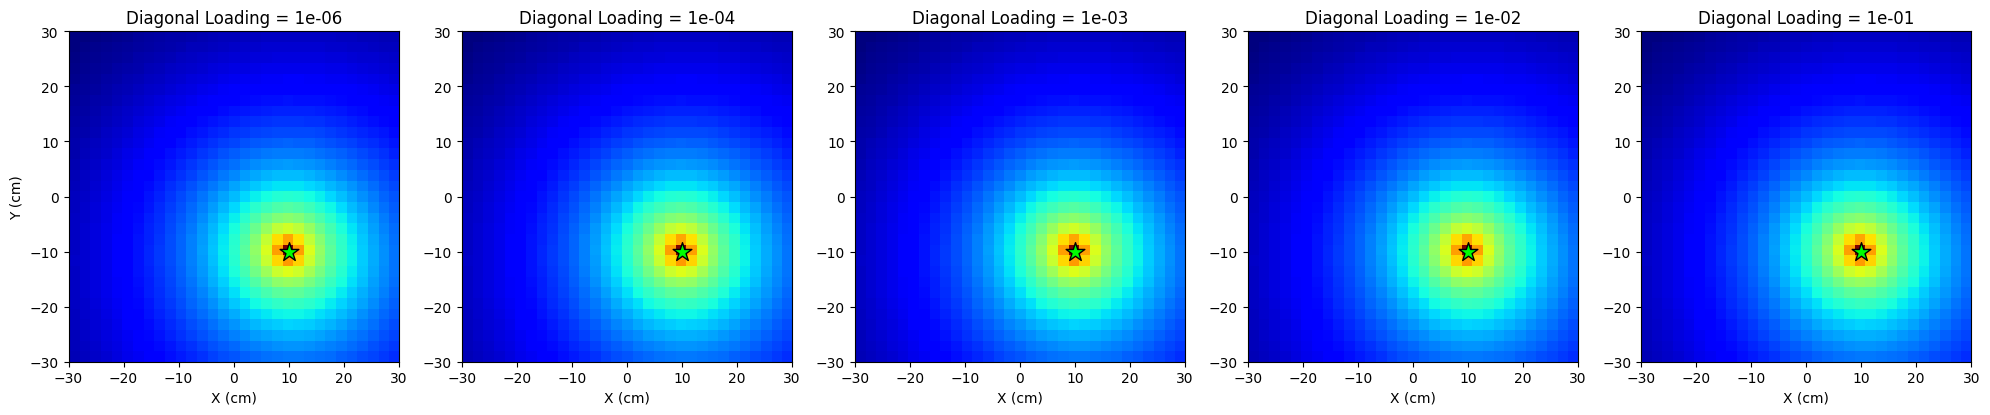

In [22]:
# Test different diagonal loading values
loading_values = [1e-6, 1e-4, 1e-3, 1e-2, 1e-1]

fig, axes = plt.subplots(1, len(loading_values), figsize=(4*len(loading_values), 4))

for ax, loading in zip(axes, loading_values):
    power = mvdr_beamformer_fast(signals, mic_positions, grid_points, sample_rate, config, 
                                  diagonal_loading=loading)
    power_db = power_to_db(power)
    power_grid = power_db.reshape(grid_shape)
    
    im = ax.imshow(power_grid, origin='lower', extent=extent, cmap='jet', aspect='equal')
    ax.scatter(source_position[0]*100, source_position[1]*100, c='lime', s=200, marker='*', edgecolors='black')
    ax.set_title(f'Diagonal Loading = {loading:.0e}')
    ax.set_xlabel('X (cm)')
    if ax == axes[0]:
        ax.set_ylabel('Y (cm)')

plt.tight_layout()
plt.show()

## Summary

| Algorithm | Resolution | Speed | Multi-source | Stability |
|-----------|------------|-------|--------------|----------|
| DAS | Low | Fast | Poor | Excellent |
| MVDR/Capon | High | Medium | Good | Good (with diagonal loading) |
| MUSIC | Very High | Slow | Excellent | Requires n_sources estimate |